Copyright (c) 2023 Graphcore Ltd. All rights reserved.

# Sampling large graphs on IPUs using PyTorch Geometric



[![Run on Gradient](../../gradient-badge.svg)](https://console.paperspace.com/github/<runtime-repo>?machine=Free-IPU-POD4&container=<dockerhub-image>&file=<path-to-file-in-repo>)  [![Join our Slack Community](https://img.shields.io/badge/Slack-Join%20Graphcore's%20Community-blue?style=flat-square&logo=slack)](https://www.graphcore.ai/join-community)

>### Link for the Run on Gradient button

> Once the notebook is available on Paperspace Gradient we like to have a "Run on Gradient" button. The link for the button needs to be configured. The example above shows the convention for how to form the link. 

> - The SVG image file for the button should be a local file in the repo (as shown in the example above). You can also use the [image file on Paperspace](https://assets.paperspace.io/img/gradient-badge.svg) but this is not reliable as Github's caching occasionally breaks.
> - `<runtime-repo>` represents the "organisation/repository-name" of the public repository that contains the notebook.
> - `<dockerhub-image>` is the name and tag of a public Docker Hub container.
> - `<path-to-file-in-repo>` is the location of the notebook inside the repo starting with a leading `/`.
>
> Note the part after the `?` in the link needs to be URL-encoded. You can use an online [URL encoder](https://www.urlencoder.org/) or you can use the [Paperspace link builder](https://docs.paperspace.com/gradient/notebooks/run-on-gradient/).
>
> Example of a fully-formed link for the "Run on Gradient" button:
> https://console.paperspace.com/github/gradient-ai/Graphcore-Pytorch?machine=Free-IPU-POD4&container=graphcore/pytorch-jupyter:3.1.0-ubuntu-20.04-20230104&file=/temporal-graph-networks/Train_TGN.ipynb

In the previous tutorials we have been focusing on working with datasets comprising many small graphs. For some modern applications, however, we will need to operate on larger graphs characterised by increasing number of nodes (range 10M-10B) and edges (range 100M-100B): imagine having to build a recommendation system for a social network type of input graph, which can be constituted by a huge number of users (nodes) and relationships (edges). 

We might think of two routes to approach large graph problems:
- full batch training: this is the approach we have been using in [Tutorial 2](https://ipu.dev/O2u8MZ) when working with a single, relatively small graph. The aim is to generate embeddings for all the nodes at the same time: this entails keeping in memory the entire graph as well as all the node embeddings. If the size of the computational graph increases, the amount of memory required to hold graph and embeddings become challenging for modern accelerators. 
- mini-batching: alternatively, we can sample mini-batches from the graph similarly to what we did in [Tutorial 3](https://ipu.dev/azOCIN) or [Tutorial 4](https://ipu.dev/lDMtKe) where the dataset was a collection of many small graphs. When sampling from a larger graph, however, we need to be extra careful to reduce the chances of the sampled nodes to be isolated from each other. Should that be the case, the mini-batches would no longer be representative of the whole graph which would negatively impact our machine learning task. The need here is to engineer effective sampling methods to make sure that the message passing scheme is still effective with large graphs. 

In this tutorial, we will demonstrate two approaches widely used in literature to cope with increasing graph size by performing message passage over mini-batches. We will leverage the Graphcore IPU architecture, which is a great fit for GNNs applications as explained in this [blog post](https://www.graphcore.ai/posts/accelerating-pyg-on-ipus-unleash-the-power-of-graph-neural-networks), and the PyTorch Geometric (PyG) integration for IPUs. You will learn how to: 
- effectively cluster nodes of your input graph; 
- sample neighbouring nodes of your input graph; 
- then, for both sampling methods, train your GNN on IPUs to classify papers from the PubMed dataset.

This notebook assumes some familiarity with PopTorch as well as PyTorch Geometric (PyG). For additional resources please consult:
- [PopTorch Documentation](https://docs.graphcore.ai/projects/poptorch-user-guide/en/latest/index.html),
- [PopTorch Examples and Tutorials](https://docs.graphcore.ai/en/latest/examples.html#pytorch),
- [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/),
- [PopTorch Geometric Documentation](https://docs.graphcore.ai/projects/poptorch-geometric-user-guide/en/latest/index.html).

[![Join our Slack
Community](https://img.shields.io/badge/Slack-Join%20Graphcore's%20Community-blue?style=flat-square&logo=slack)](https://www.graphcore.ai/join-community)

In [53]:
# Make imported python modules automatically reload when the files are changed
# needs to be before the first import.
%load_ext autoreload
%autoreload 2
# TODO: remove at the end of notebook development

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Environment setup

The best way to run this demo is on Paperspace Gradient's cloud IPUs because everything is already set up for you. To run the demo using other IPU hardware, you need to have the Poplar SDK enabled and the latest PopTorch Geometric wheel installed. Refer to the [getting started guide](https://docs.graphcore.ai/en/latest/getting-started.html#getting-started) for your system for details on how to enable the Poplar SDK and install the PopTorch wheels.

> You can install requirements directly from a notebook. You can:
>
> 1. Run commands by starting the line in a code cell with `!`, as shown in the first code block below. 
> 2. Install Python requirements with the `%pip` [magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html).
> 
> Use these methods to make it easier for your user to set up the environment they need.

In [54]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


To make it easier for you to run this tutorial, we read in some configuration related to the environment you are running the notebook in.

In [55]:
import os

dataset_directory = os.getenv("DATASETS_DIR", "data")

## Clustering the computation graph for node classification

The idea behind this method is that we can sample the entire input graph in smaller sub-graphs that individually fit in memory and on which we can calculate layer-wise embeddings, performing message passing on one sub-graph at the time.
The sub-graph should also retain the connectivity of the original graph to avoid information loss: to achieve that we make sure that the small communities the original graph is made up of are mirrored in the generated sub-graphs.

A well known approach is [Cluster-GCN](https://arxiv.org/abs/1905.07953). The steps are:
- pre-processing: given a large graph, we partition it into group of nodes we name sub-graphs.
- mini-batch training: we load one sub-graph at the time in the device memory and apply message passing over it to compute the loss.

You can also check out our dedicated [Cluster-GCN example.](https://ipu.dev/PmAtSw)

### Cluster-GCN in PyG on IPUs

First, let's load the `PubMed` dataset from the `Planetoid` node classification benchmarking suite and print some statistics about it.

In [56]:
import torch
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

transform = T.Compose([T.NormalizeFeatures(), T.AddSelfLoops()])

dataset = Planetoid(root=dataset_directory, name="PubMed", transform=transform)
data = dataset[0]  # Access the graph as Data object

print(f"Dataset: {dataset} ")
print(f"Number of graphs: {len(dataset)}: ")
print(f"Number of features: {dataset.num_features} ")
print(f"Number of classes: {dataset.num_classes} ")

print(data)

print(f"Total number of nodes: {data.num_nodes}")
print(f"Total number of edges: {data.num_edges}")

Dataset: PubMed() 
Number of graphs: 1: 
Number of features: 500 
Number of classes: 3 
Data(x=[19717, 500], edge_index=[2, 108365], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
Total number of nodes: 19717
Total number of edges: 108365


The dataset consists of 19717 scientific publications from the PubMed database relative to diabetes classified into one of three classes. This is not a huge dataset, but it will serve our purpose to demonstrate the sampling approaches. 
Let's now proceed with the clustering. The first step is to use `ClusterData` to partition our `Data` object into `num_clusters` clusters: under the hood it leverages the METIS algorithm to obtain the split.

In [57]:
from torch_geometric.loader import ClusterData

num_clusters = 100

cluster_data = ClusterData(
    data, num_parts=num_clusters, recursive=False, save_dir=dataset_directory
)

print(f"The dataset has been split in {len(cluster_data)} clusters")

The dataset has been split in 100 clusters


We can now inspect the composition of a couple of clusters, for example:

In [58]:
cluster_data[50], cluster_data[60]

(Data(x=[196, 500], y=[196], train_mask=[196], val_mask=[196], test_mask=[196], edge_index=[2, 626]),
 Data(x=[202, 500], y=[202], train_mask=[202], val_mask=[202], test_mask=[202], edge_index=[2, 706]))

You will observe how each cluster contains a different number of nodes and edges, which we will need to keep in mind when preparing the mini-batches to feed into the IPU. The IPU relies on Ahead-Of-Time (AOT) compilation hence it needs the input tensors to be fixed sizes. The mini-batches that we will load onto the IPU will be the result of combining clusters together, hence each mini-batch will have a different size.  We need to make sure that the mini-batches are fixed in size so they can be loaded correctly into the IPU. 

We can leverage the `Summary` API in PyG to find out the maximum number of nodes and edges in each cluster:

In [59]:
from torch_geometric.data.summary import Summary

cluster_summary = Summary.from_dataset(cluster_data)
cluster_summary

ClusterData (#graphs=100):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |    197.2 |    803.7 |
| std        |      4.7 |    199.2 |
| min        |    191   |    581   |
| quantile25 |    192.8 |    666.5 |
| median     |    197   |    740   |
| quantile75 |    202   |    858   |
| max        |    203   |   1497   |
+------------+----------+----------+

We can use this information to calculate the maximum number of nodes that we would like to have in each mini-batch, which will also be consistent across mini-batches. To do so we also need to choose how many clusters we'd like to have in each mini-batch (equivalent to choosing a `batch_size` in Tutorial 3), let's set it to 10:

In [60]:
clusters_per_batch = 10  # batch_size

max_num_nodes_per_cluster = int(cluster_summary.num_nodes.max)
max_nodes_per_batch = max_num_nodes_per_cluster * clusters_per_batch + 1

max_nodes_per_batch

2031

Let's keep in mind we will also need to number of edges to be consistent across mini-batches to work with fixed sizes on the IPU: this means we will need to apply some padding to the number of edges. In the code cell above we added one dummy node to the maximum number of nodes in each mini-batch so that we can use it to link all the padded edges to it as self-loops. Now let's calculate the number of edges: we need to approximate it using the average statistics printed above, to which we will add its standard deviation.

In [61]:
max_edges_per_batch = int(cluster_summary.num_edges.mean) + int(
    cluster_summary.num_edges.std
)
max_edges_per_batch *= clusters_per_batch
max_edges_per_batch

10020

You might already be familiar with the PyG `ClusterLoader` to implement the stochastic partitioning scheme in CLuster-GCN given a user defined `batch_size` . To comply with the AOT compilation requirement on IPUs we will use instead `FixedSizeClusterLoader` from PopTorch Geometric, where we can specify the number of nodes and edges to be fixed in every mini-batch and equal to the quantities calculated in the previous two cells:

In [62]:
import poptorch
from poptorch_geometric.cluster_loader import FixedSizeClusterLoader

train_dataloader = FixedSizeClusterLoader(
    cluster_data,
    batch_size=clusters_per_batch,
    num_nodes=max_nodes_per_batch,
    collater_args=dict(num_edges=max_edges_per_batch, trim_edges=True),
    num_workers=8,
)

Let's now inspect a couple of mini-batches loaded by the dataloader:

In [63]:
train_dataloader_iter = iter(train_dataloader)
print(f"{next(train_dataloader_iter) = }")
print(f"{next(train_dataloader_iter) = }")

next(train_dataloader_iter) = DataBatch(x=[2031, 500], edge_index=[2, 10020], y=[2031], batch=[2031], ptr=[3], test_mask=[2031], train_mask=[2031], val_mask=[2031], num_nodes=2031, num_edges=10020)
next(train_dataloader_iter) = DataBatch(x=[2031, 500], edge_index=[2, 10020], y=[2031], batch=[2031], ptr=[3], test_mask=[2031], train_mask=[2031], val_mask=[2031], num_nodes=2031, num_edges=10020)


As expected, we can appreciate how each mini-batch has the same number of nodes and edges that we specified earlier (610 and 3006 respectively). All the tensor shapes are consistent across mini-batches too. Now that we have clustered and loaded the data compatibly with the AOT requirements of the IPU, the next step is to train a GNN model to classify the papers in our dataset.

### Training a GNN to classify papers in the PubMed dataset

The first step is to define a GNN model to carry out our classification task. We can easily re-use one of the models we defined in the previous tutorials, for example a simple GCN-based one, as using clustering does not impact model definition:

In [64]:
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super(GCN, self).__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(in_channels, 64, add_self_loops=False)
        self.conv2 = GCNConv(64, out_channels, add_self_loops=False)

    def forward(self, x, edge_index, train_mask=None, y=None):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.log_softmax(x, dim=-1)

        if self.training:
            y = torch.where(train_mask, y, -100)
            loss = F.nll_loss(x, y)
            return x, loss
        return x

We can now create the PopTorch model and train it on the IPU:

In [65]:
model = GCN(dataset.num_features, dataset.num_classes)
model

GCN(
  (conv1): GCNConv(500, 64)
  (conv2): GCNConv(64, 3)
)

In [66]:
from torchinfo import summary

model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005)
poptorch_model = poptorch.trainingModel(model, optimizer=optimizer)

summary(poptorch_model)

Layer (type:depth-idx)                   Param #
PoplarExecutor                           --
├─GCNConv: 1-1                           64
│    └─SumAggregation: 2-1               --
│    └─Linear: 2-2                       32,000
├─GCNConv: 1-2                           3
│    └─SumAggregation: 2-3               --
│    └─Linear: 2-4                       192
Total params: 32,259
Trainable params: 32,259
Non-trainable params: 0

Training loop looks like this:

In [67]:
from tqdm import tqdm

num_epochs = 5
train_losses = torch.empty(num_epochs, len(train_dataloader))

for epoch in range(num_epochs):
    bar = tqdm(train_dataloader)
    for i, data in enumerate(bar):
        _, mini_batch_loss = poptorch_model(
            data.x, data.edge_index, data.train_mask, data.y
        )
        train_losses[epoch, i] = float(mini_batch_loss.mean())
        bar.set_description(
            f"Epoch {epoch} training loss: {train_losses[epoch, i].item():0.6f}"
        )

  0%|          | 0/10 [00:00<?, ?it/s][15:10:53.158] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 304
[15:10:53.159] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 306
[15:10:53.191] [poptorch:cpp] [warning] %108 : float = prim::Constant() # /tmp/ipykernel_3226947/4056117028.py:14:0: torch.float64 constant cannot be represented as a torch.float32
[15:10:53.192] [poptorch:cpp] [warning] %234 : float = prim::Constant() # /tmp/ipykernel_3226947/4056117028.py:16:0: torch.float64 constant cannot be represented as a torch.float32
Epoch 4 training loss: 1.011515: 100%|██████████| 10/10 [00:00<00:00, 112.90it/s]


We can now detach the training model from the IPU:

In [68]:
poptorch_model.detachFromDevice()

Finally we can plot the mean of the loss to verify it decreases nicely:

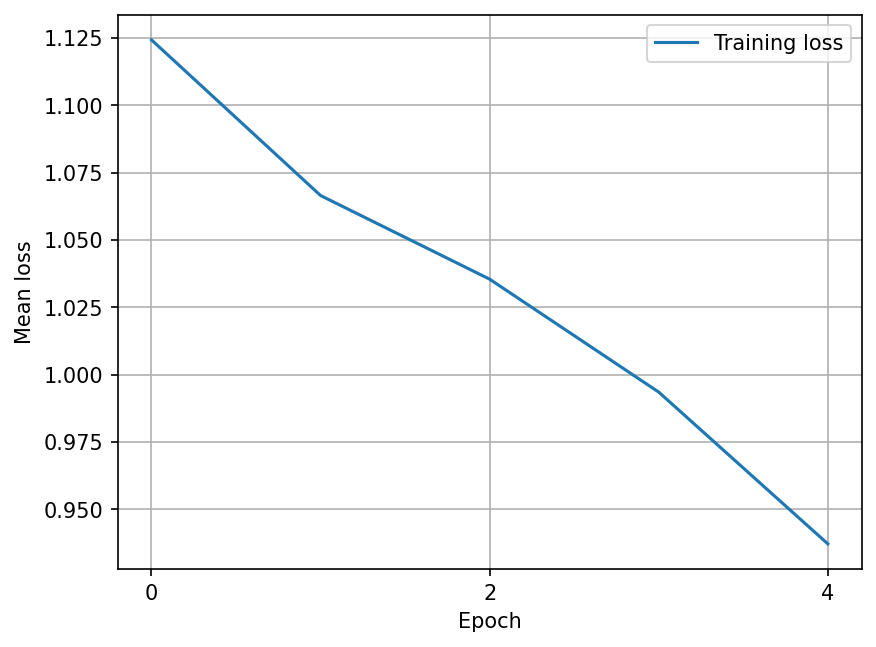

In [69]:
import matplotlib.pyplot as plt

plt.plot(train_losses.mean(dim=1))
plt.xlabel("Epoch")
plt.ylabel("Mean loss")
plt.legend(["Mean training loss per epoch"])
plt.xticks(torch.arange(0, num_epochs, 2))
plt.gcf().set_dpi(150)

## Neighbourhood sampling the computation graph for node classification

The neighbourhood sampling approach was firstly introduced in the [GraphSAGE](https://arxiv.org/abs/1706.02216v4) (SAmple and AGrEgate) paper for creating inductive node embeddings: the idea here is to learn how to aggregate node feature information from a node's K-hop neighbourhood, where K is the number of layers of our GNN and the number of iterations we want to perform. This means we need relatively small memory requirements: to generate the embeddings of a node we only need to know the K-hop neighbourhood structure around that node and the relative nodes' features, we don't need to store the rest of the graph. In this way, the mini-batches are going to be made of K-hop neighbourhoods which should fit nicely into the device's memory. 

### Neighbour sampling in PyG on IPUs 

PyG provides the `NeighborLoader`, a data loader that performs neighbour sampling as per the GraphSAGE paper, allowing for mini-batching when full-batch update is not feasible. We can select how many neighboring nodes we'd like to be sampled for each node in each iteration, as well as the number of iterations (or number of hops) we'd like to go through. In this case, the `batch_size` argument represents how many nodes we want to sample from, which we can agree to refer to as 'target' nodes. Let's take a look at how to implement this in code: 

In [70]:
from torch_geometric.loader import NeighborLoader

num_neighbors = 10
num_iterations = 2

kwargs = {
    "batch_size": 5
}  # TODO test additional kwargs 'num_workers': 6, 'persistent_workers': True

train_loader_sampling = NeighborLoader(
    data,
    # shuffle = True,
    num_neighbors=[num_neighbors] * num_iterations,
    **kwargs,
)

train_sampling_iter = iter(train_loader_sampling)
print(f"{next(train_sampling_iter) = }")
print(f"{next(train_sampling_iter) = }")

sampled_data = next(train_sampling_iter)
print(
    f"Original graph node index of each target node in the mini-batch: {sampled_data.input_id}"
)
print(
    f"Original graph node index of each node in the mini-batch: {sampled_data.n_id}"
)  # shows the target nodes are the first 5

next(train_sampling_iter) = DataBatch(x=[44, 500], edge_index=[2, 47], y=[44], ptr=[3], test_mask=[44], train_mask=[44], val_mask=[44], num_nodes=44, num_edges=10020, n_id=[44], e_id=[47], input_id=[5], batch_size=5)
next(train_sampling_iter) = DataBatch(x=[39, 500], edge_index=[2, 44], y=[39], ptr=[3], test_mask=[39], train_mask=[39], val_mask=[39], num_nodes=39, num_edges=10020, n_id=[39], e_id=[44], input_id=[5], batch_size=5)
Original graph node index of each target node in the mini-batch: tensor([10, 11, 12, 13, 14])
Original graph node index of each node in the mini-batch: tensor([  10,   11,   12,   13,   14,  106,  163, 1466,    5,  176, 1945,  119,
          66,  111,  741,   86,  116,  133,    2,   16, 1563, 1549, 1290, 1544,
         770, 1723,  292, 1621,  412,  124,  101,  192, 1639,   36, 1399,  156,
        1910,   55])


/localdata/ariannas/3.3.0+1337-EA.1/3.3.0+1337_poptorch/lib/python3.8/site-packages/torch_geometric/sampler/neighbor_sampler.py:50: UserWarning: Using '{self.__class__.__name__}' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn("Using '{self.__class__.__name__}' without a "



In PyG, sampled nodes are sorted based on the order they were sampled. In fact, from inspecting the elements in the iterator, we can see how the first `batch_size` nodes (5 in this case) in the sampled sub-graph are the target ones, in other terms they represent the set of original mini-batch nodes. Those nodes are the ones we will want to use for training later on.
To comply with the AOT requirement in PopTorch on IPUs, we need to take action on those variable tensor sizes shown in the above cell and make them fixed size. To this purpose, we leverage the `FixedSizeNeighborLoader` in PopTorch Geometric: under the hood, this class takes the sub-graphs generated by the PyG `NeighborLoader` and then applies the PopTorch Geometric `FixedSizeCollater` to make the resulting shapes of the sub-graphs fixed size across sub-graphs.

In [71]:
from typing import Callable, Dict, List, Optional, Tuple, Union

import poptorch
import torch
from poptorch_geometric.collate import FixedSizeCollater
from poptorch_geometric.collate import CombinedBatchingCollater
from torch_geometric.data import Data, FeatureStore, GraphStore, HeteroData
from torch_geometric.loader import NeighborLoader
from torch_geometric.loader.utils import get_input_nodes
from torch_geometric.sampler import NeighborSampler
from torch_geometric.typing import EdgeType, InputNodes, OptTensor

# TODO: Tidy
# TODO: Fix below issues
# TODO: Heuristic for setting num_neighbours?
# TODO: Verify pruning doesn't happen on the wrong bits - that the IDs still align correctly
# TODO: Add padded node and edge to original graph and pad the e_id and n_id with ids of that padded node / edge

"""
Known issues:
 - `batch_size` must be added to `exclude_keys` as it the FixedSizeCollator doesn't handle it correctly
 - `e_id` and `n_id` not padded correctly - requires this change to upstream:https://github.com/pyg-team/pytorch_geometric/blob/master/torch_geometric/data/storage.py#L653
    '''
    if key in E_KEYS:
        self._cached_attr[AttrType.EDGE].add(key)
        return True
    else:
        self._cached_attr[AttrType.NODE].add(key)
        return False
    '''
 - Trimming needs to be input_id aware - shouldn't prune the batch ids
 - Input ids, get doubled when the call to the default collater happens, caused by: https://github.com/pyg-team/pytorch_geometric/blob/master/torch_geometric/loader/dataloader.py#L12
    `batch = super().__call__(data_list)`
"""


class PyGFixedSizeNeighborLoader(torch.utils.data.DataLoader):
    def __init__(
        self,
        data: Union[Data, HeteroData, Tuple[FeatureStore, GraphStore]],
        num_neighbors: Union[List[int], Dict[EdgeType, List[int]]],
        input_nodes: InputNodes = None,
        input_time: OptTensor = None,
        replace: bool = False,
        directed: bool = True,
        disjoint: bool = False,
        temporal_strategy: str = "uniform",
        time_attr: Optional[str] = None,
        transform: Optional[Callable] = None,
        transform_sampler_output: Optional[Callable] = None,
        is_sorted: bool = False,
        filter_per_worker: bool = False,
        batch_size: int = 1,
        neighbor_sampler: Optional[NeighborSampler] = None,
        collater_args: Optional[Dict[str, Union[int, float]]] = None,
        **kwargs,
    ):
        self.batch_size = batch_size
        self.neighbour_loader = NeighborLoader(
            data,
            num_neighbors,
            input_nodes=input_nodes,
            input_time=input_time,
            replace=replace,
            directed=directed,
            disjoint=disjoint,
            temporal_strategy=temporal_strategy,
            time_attr=time_attr,
            transform=transform,
            transform_sampler_output=transform_sampler_output,
            is_sorted=is_sorted,
            filter_per_worker=filter_per_worker,
            neighbor_sampler=neighbor_sampler,
        )
        _, input_nodes = get_input_nodes(data, input_nodes)

        collater_args = collater_args if collater_args else {}
        collater = self._create_collater(**collater_args)
        super().__init__(
            dataset=range(input_nodes.size(0)),
            batch_size=self.batch_size,
            collate_fn=collater,
            **kwargs,
        )

    def __collate__(self, index):
        out = self.neighbour_loader.collate_fn(index)
        out = self.fixed_size_collater([out])
        return out

    def _create_collater(self, **collater_args):
        self.fixed_size_collater = FixedSizeCollater(**collater_args)
        return self.__collate__


class FixedSizeNeighborLoader(PyGFixedSizeNeighborLoader, poptorch.DataLoader):
    def __init__(
        self,
        data: Union[Data, HeteroData, Tuple[FeatureStore, GraphStore]],
        num_neighbors: Union[List[int], Dict[EdgeType, List[int]]],
        input_nodes: InputNodes = None,
        input_time: OptTensor = None,
        replace: bool = False,
        directed: bool = True,
        disjoint: bool = False,
        temporal_strategy: str = "uniform",
        time_attr: Optional[str] = None,
        transform: Optional[Callable] = None,
        transform_sampler_output: Optional[Callable] = None,
        is_sorted: bool = False,
        filter_per_worker: bool = False,
        batch_size: int = 1,
        neighbor_sampler: Optional[NeighborSampler] = None,
        collater_args: Optional[Dict[str, Union[int, float]]] = None,
        options: Optional[poptorch.Options] = None,
        **kwargs,
    ):
        self.batch_size = batch_size

        if options is None:
            # Create IPU default options
            options = poptorch.Options()

        super().__init__(
            data,
            num_neighbors,
            input_nodes=input_nodes,
            input_time=input_time,
            replace=replace,
            directed=directed,
            disjoint=disjoint,
            temporal_strategy=temporal_strategy,
            time_attr=time_attr,
            transform=transform,
            transform_sampler_output=transform_sampler_output,
            is_sorted=is_sorted,
            filter_per_worker=True,
            batch_size=batch_size,
            neighbor_sampler=neighbor_sampler,
            collater_args=collater_args,
            options=options,
            **kwargs,
        )

    def _create_collater(self, **collater_args):
        collater = super()._create_collater(**collater_args)
        return CombinedBatchingCollater(
            mini_batch_size=self.batch_size, collater=collater
        )

In [72]:
import torch_geometric.data.storage

import torch
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

transform = T.Compose([T.NormalizeFeatures(), T.AddSelfLoops()])

dataset = Planetoid(root=dataset_directory, name="PubMed", transform=transform)
data = dataset[0]  # Access the graph as Data object

train_loader_ipu = FixedSizeNeighborLoader(
    data,
    num_neighbors=[num_neighbors] * num_iterations,
    collater_args={
        "num_nodes": 1000,  # argument for the FixedSizeCollater to pad the sub-graph up to those sizes
        "num_edges": 50000,  # argument for the FixedSizeCollater to pad the sub-graph up to those sizes
        "trim_edges": True,
        "trim_nodes": True,
        "exclude_keys": ("batch_size",),
        "add_masks_to_batch": True,
    },
    **kwargs,
)

train_loader_ipu_iter = iter(train_loader_ipu)
print(f"{next(train_loader_ipu_iter) = }")
print(f"{next(train_loader_ipu_iter) = }")
print(
    f"{next(train_loader_ipu_iter).input_id = }"
)  # Note, input_ids is 2*batch_size instead of batch_size. 

next(train_loader_ipu_iter) = DataBatch(x=[1000, 500], edge_index=[2, 50000], y=[1000], batch=[1000], e_id=[50000], edges_mask=[50000], graphs_mask=[2], input_id=[10], n_id=[1000], nodes_mask=[1000], ptr=[3], test_mask=[1000], train_mask=[1000], val_mask=[1000], num_nodes=1000, num_edges=50000)
next(train_loader_ipu_iter) = DataBatch(x=[1000, 500], edge_index=[2, 50000], y=[1000], batch=[1000], e_id=[50000], edges_mask=[50000], graphs_mask=[2], input_id=[10], n_id=[1000], nodes_mask=[1000], ptr=[3], test_mask=[1000], train_mask=[1000], val_mask=[1000], num_nodes=1000, num_edges=50000)
next(train_loader_ipu_iter).input_id = tensor([10, 11, 12, 13, 14,  0,  0,  0,  0,  0])


As we can see, the resulting sub-graphs have now fixed sizes! 

### Training a GNN to classify papers in the PubMed dataset

We will use a slight modification of the model we defined for the clustering approach demonstration and repeat the same steps to carry out our node classification task. We will leverage the `SAGEConv()` PyG layer to perform one iteration of the aggregate-and-update step. The selected aggregation scheme is the default one, a mean. The main aspect to be careful about is selecting which nodes we actually want to consider for training in each sub-graph. We need to make sure we train on those nodes we defined as the target ones and that we leave out of the loss calculation the padding sub-graph in each sub-graph. 

In [73]:
from torch_geometric.nn import SAGEConv

batch_size = 5


class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super(GraphSAGE, self).__init__()
        torch.manual_seed(1234)
        self.conv1 = SAGEConv(
            in_channels, 64, add_self_loops=False
        )  # might not need self loops here?
        self.conv2 = SAGEConv(64, out_channels, add_self_loops=False)

    def forward(self, x, edge_index, train_mask=None, y=None):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.log_softmax(x, dim=-1)

        if self.training:
            loss = F.nll_loss(x[:batch_size], y[:batch_size])  # Select only the target nodes for loss calculation, leave out the padding sub-graph in each sub-graph
            return x, loss
        return x

In [74]:
model_sampling = GraphSAGE(dataset.num_features, dataset.num_classes)
model_sampling

GraphSAGE(
  (conv1): SAGEConv(500, 64, aggr=mean)
  (conv2): SAGEConv(64, 3, aggr=mean)
)

In [75]:
from torchinfo import summary

model_sampling.train()
optimizer = poptorch.optim.Adam(model_sampling.parameters(), lr=0.001)
poptorch_model_sampling = poptorch.trainingModel(model_sampling, optimizer=optimizer)

summary(poptorch_model_sampling)

Layer (type:depth-idx)                   Param #
PoplarExecutor                           --
├─SAGEConv: 1-1                          --
│    └─MeanAggregation: 2-1              --
│    └─Linear: 2-2                       32,064
│    └─Linear: 2-3                       32,000
├─SAGEConv: 1-2                          --
│    └─MeanAggregation: 2-4              --
│    └─Linear: 2-5                       195
│    └─Linear: 2-6                       192
Total params: 64,451
Trainable params: 64,451
Non-trainable params: 0

In [76]:
from tqdm import tqdm
import numpy as np

num_epochs = 5
epoch_losses = torch.empty(num_epochs, len(train_loader_ipu))
print(len(train_loader_ipu))

for epoch in range(num_epochs):
    bar = tqdm(train_loader_ipu)
    for i, data in enumerate(bar):
        _, mini_batch_loss = poptorch_model_sampling(
            data.x, data.edge_index, data.train_mask, data.y
        )
        epoch_losses[epoch, i] = float(mini_batch_loss.mean())
        bar.set_description(
            f"Epoch {epoch} training loss: {epoch_losses[epoch, i].item():0.6f}"
        )

3943


  0%|          | 0/3943 [00:00<?, ?it/s][15:11:23.498] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 401
[15:11:23.499] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 403
Epoch 4 training loss: 0.018384: 100%|██████████| 3943/3943 [00:23<00:00, 168.27it/s]


In [77]:
# poptorch_model.detachFromDevice()

Error: 'poptorch_py_error': Device is not attached

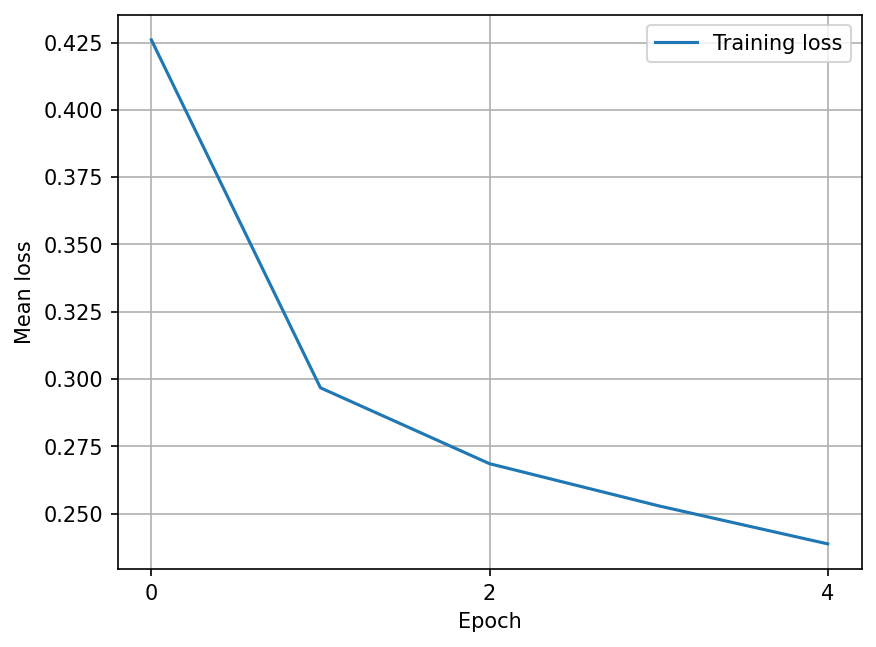

In [78]:
import matplotlib.pyplot as plt

plt.plot(epoch_losses.mean(dim=1))
plt.xlabel("Epoch")
plt.ylabel("Mean loss")
plt.legend(["Mean training loss per epoch"])
plt.grid(True)
plt.xticks(torch.arange(0, num_epochs, 2))
plt.gcf().set_dpi(150)

In [ ]:
if model.isAttachedToDevice():
    model.detachFromDevice()

AttributeError: 'PoptorchGCN' object has no attribute 'isAttachedToDevice'

## Conclusion

In this tutorial we explored the main methods to deal with large graphs that otherwise wouldn't fit in memory, using two different sampling approaches and dedicated dataloaders to optimise performance on Graphcore IPUs. 

We demonstrated:
- how to effectively cluster nodes of your input graph, leveraging the `FixedSizeClusterLoader` to do so while respecting the AOT requirements on the IPU;
- hot to sample neighbouring nodes of your input graph, using the `FixedSizeNeighborLoader`;
- then, for both sampling methods above, how train your GNN on IPUs to classify papers from the PubMed dataset.

So far in this tutorial series we have worked with homogeneous graphs, however scaled up GNN problems are also very well suited to heterogeneous graphs: please check out our [heterogeneous graph tutorial](TODO add link) to know more about how to handle those on IPUs. More extensive node classification examples can be found in our  Gradient-Pytorch-Geometric/node-prediction repository. 

